1. (2x) LASSO regression for electronic band gap.


(a) Read in the JSON file with the cleaned electronic band gap data for rocksalt structure, and the JSON file with the elemental properties. Convert both to dictionary-like objects.

In [2]:
import json
from google.colab import drive
drive.mount('/content/drive')

f = open("/content/drive/MyDrive/Colab Notebooks/rocksalt_Egap_insulators_AFLOW.json", "r+")
zincblende_EgapClean = json.load(f)
f.close()
print(zincblende_EgapClean)  #  already dictionary-like object

f2 = open("/content/drive/MyDrive/Colab Notebooks/Chemical_element_data.json", "r+")
Chemical_element_data = json.load(f2)
f2.close()
print(Chemical_element_data)  #  already dictionary-like object

drive.flush_and_unmount()

Mounted at /content/drive
[{'compound': 'Ag1Br1', 'auid': 'aflow:1ffe490975e7aeeb', 'aurl': 'aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/FCC/Ag1Br1_ICSD_52246', 'spacegroup_relax': 225, 'Pearson_symbol_relax': 'cF8', 'species': ['Ag', 'Br'], 'Egap': 1.5727, 'Egap_type': 'insulator-indirect', 'aflow_prototype_label_relax': 'AB_cF8_225_a_b'}, {'compound': 'Ag1Cl1', 'auid': 'aflow:1b9d91d05f2e4c8c', 'aurl': 'aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/FCC/Ag1Cl1_ICSD_64734', 'spacegroup_relax': 225, 'Pearson_symbol_relax': 'cF8', 'species': ['Ag', 'Cl'], 'Egap': 1.9714, 'Egap_type': 'insulator-indirect', 'aflow_prototype_label_relax': 'AB_cF8_225_a_b'}, {'compound': 'Ag1F1', 'auid': 'aflow:bcee7bb7be81cfb8', 'aurl': 'aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/FCC/Ag1F1_ICSD_18008', 'spacegroup_relax': 225, 'Pearson_symbol_relax': 'cF8', 'species': ['Ag', 'F'], 'Egap': 1.0812, 'Egap_type': 'insulator-indirect', 'aflow_prototype_label_relax': 'AB_cF8_225_a_b'}, {'compound': 'Ag1I1', 'auid': 'aflow:382493c94d10

(b) Generate the feature vectors based on the means and differences of the electronegativities, ionization energies, valences and atomic masses (8 features, see example in Lecture 17). Generate the training and test sets.

In [3]:
x_list = []
y_list = []

for datum in zincblende_EgapClean:
    species1 = datum["species"][0]
    species2 = datum["species"][1]
    en_mean = abs(Chemical_element_data[species1]["electronegativity"] + Chemical_element_data[species2]["electronegativity"]) / 2.0
    en_diff = abs(Chemical_element_data[species1]["electronegativity"] - Chemical_element_data[species2]["electronegativity"])
    ie_mean = abs(Chemical_element_data[species1]["first_ionization_energy"] + Chemical_element_data[species2]["first_ionization_energy"]) / 2.0
    ie_diff = abs(Chemical_element_data[species1]["first_ionization_energy"] - Chemical_element_data[species2]["first_ionization_energy"])
    val_mean = abs(Chemical_element_data[species1]["valence"] + Chemical_element_data[species2]["valence"]) / 2.0
    val_diff = abs(Chemical_element_data[species1]["valence"] - Chemical_element_data[species2]["valence"])
    am_mean = abs(Chemical_element_data[species1]["atomic_mass"] + Chemical_element_data[species2]["atomic_mass"]) / 2.0
    am_diff = abs(Chemical_element_data[species1]["atomic_mass"] - Chemical_element_data[species2]["atomic_mass"])
    x_list.append([en_mean, en_diff, ie_mean, ie_diff, val_mean, val_diff, am_mean, am_diff])
    y_list.append(float(datum["Egap"]))

print(x_list)
print(y_list)

#  Training and testing sets will be generated in part (c)

[[2.3499999999999996, 0.8999999999999999, 936.0, 408.0, 4.0, 6.0, 93.898, 27.964], [2.45, 1.1, 996.0, 528.0, 4.0, 6.0, 71.6685, 72.423], [2.95, 2.1, 1206.0, 948.0, 4.0, 6.0, 63.44, 88.88], [2.2, 0.6000000000000001, 871.0, 278.0, 4.0, 6.0, 117.4, 19.040000000000006], [2.25, 1.5, 988.5, 823.0, 4.0, 2.0, 20.488999999999997, 12.962], [2.2, 2.6, 906.0, 808.0, 4.0, 4.0, 76.68, 121.36000000000001], [1.7, 1.6, 751.0, 498.0, 4.0, 4.0, 84.71300000000001, 105.29400000000001], [1.65, 1.5, 271.5, 461.0, 4.0, 4.0, 108.16, 58.40000000000002], [1.5, 1.2000000000000002, 686.0, 368.0, 4.0, 4.0, 132.485, 9.750000000000014], [2.5, 2.0, 1105.0, 410.0, 4.0, 4.0, 12.506499999999999, 6.987], [2.0, 1.0, 950.0, 100.0, 4.0, 4.0, 20.5395, 23.053000000000004], [1.7999999999999998, 1.9999999999999998, 779.0, 722.0, 4.0, 6.0, 59.506, 40.82], [1.7999999999999998, 1.9999999999999998, 771.0, 738.0, 4.0, 6.0, 82.69800000000001, 5.564000000000007], [2.25, 2.5, 950.0, 720.0, 4.0, 4.0, 28.04, 24.08], [1.75, 1.5, 795.0, 410

(c) Split the data into testing and training sets. Fit LASSO with the default value of alpha to the training set. What is the score for the test set? How many features have non-zero coefficients? Which features have non-zero coefficients?

In [4]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import numpy as np

x = np.array(x_list)
y = np.array(y_list)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)
lasso = Lasso().fit(x_train, y_train)

print("Training set score: ", lasso.score(x_train, y_train))
print("Testing set score: ", lasso.score(x_test, y_test))
print()

nonzero_indices = []
nonzero_features = []

for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        nonzero_indices.append(i)
        nonzero_features.append(lasso.coef_[i])

print("Number of features with non-zero coefficients: ", len(nonzero_indices))
print()

feature_names = ["Electronegativity mean", "Electronegativity difference", "First ionization energy mean", "First ionization energy difference", "Valence mean", "Valence difference", "Atomic mass mean", "Atomic mass difference"]
print("Features with non-zero coefficients: ")

for j in range(len(nonzero_indices)):
    print(str(feature_names[nonzero_indices[j]]) + ": " + str(nonzero_features[j]))

Training set score:  0.4481586434081787
Testing set score:  0.37879791758038717

Number of features with non-zero coefficients:  5

Features with non-zero coefficients: 
First ionization energy mean: 0.00040723095537326874
First ionization energy difference: 0.0032991124755581305
Valence difference: 0.04565344051327924
Atomic mass mean: -0.0006166031808751501
Atomic mass difference: -0.01706358425296247


(d) Use Grid Search to optimize the value of alpha. What is the score for the test set with the optimum value of alpha?

In [5]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

#  Generate testing & training sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)

#  Generate dict containing alpha values
param_grid = {"alpha":[0.001, 0.001, 0.01, 0.1, 1.0, 10, 100]}

#  Instantiate GridSearchCV object, and fit to training set
grid_search = GridSearchCV(lasso, param_grid)
grid_search.fit(x_train, y_train)

#  Generate training and testing scores
print("Accuracy on training set: ", grid_search.score(x_train, y_train))
print("Accuracy on test set: ", grid_search.score(x_test, y_test))

#  Print out parameters leading to best Lasso model
print("Best estimator: ", grid_search.best_estimator_)

Accuracy on training set:  0.608413321869014
Accuracy on test set:  0.6645204464032902
Best estimator:  Lasso(alpha=0.1)




(e) Fit LASSO to the full training set, using the parameters from the best model from part (d). What is the score for the test set? How many features have non-zero coefficients? Which features have non-zero coefficients?


In [6]:
best_lasso = grid_search.best_estimator_.fit(x_train, y_train)

print("Accuracy on training set: ", best_lasso.score(x_train, y_train))
print("Accuracy on test set: ", best_lasso.score(x_test, y_test))
print()

nonzero_indices = []
nonzero_features = []

for i in range(len(best_lasso.coef_)):
    if best_lasso.coef_[i] != 0:
        nonzero_indices.append(i)
        nonzero_features.append(best_lasso.coef_[i])

print("Number of features with non-zero coefficients: ", len(nonzero_indices))
print()

feature_names = ["Electronegativity mean", "Electronegativity difference", "First ionization energy mean", "First ionization energy difference", "Valence mean", "Valence difference", "Atomic mass mean", "Atomic mass difference"]
print("Features with non-zero coefficients: ")

for j in range(len(nonzero_indices)):
    print(str(feature_names[nonzero_indices[j]]) + ": " + str(nonzero_features[j]))

Accuracy on training set:  0.608413321869014
Accuracy on test set:  0.6645204464032902

Number of features with non-zero coefficients:  7

Features with non-zero coefficients: 
Electronegativity difference: 0.341369541201267
First ionization energy mean: 0.0002588652796144679
First ionization energy difference: 0.002014515887598828
Valence mean: -0.3051469542486447
Valence difference: 0.3441005291807519
Atomic mass mean: -0.0029593194595481636
Atomic mass difference: -0.014009678225717094


2. (2x) Decision trees classification for electronic band gap type.


(a) Read in the JSON file with the cleaned electronic band gap type data for rocksalt structure, and the JSON file with the elemental properties. Convert both to dictionary-like objects.

In [7]:
import json, sys, os
from google.colab import drive
drive.mount('/content/drive')

f = open("/content/drive/MyDrive/Colab Notebooks/rocksalt_Egaptype_AFLOW.json", "r+")
zincblende_EgaptypeClean = json.load(f)
f.close()
# print(zincblende_EgaptypeClean)  #  already in dictionary-like form

f2 = open("/content/drive/MyDrive/Colab Notebooks/Chemical_element_data.json", "r+")
Chemical_element_data = json.load(f2)
f2.close()
# print(Chemical_element_data)  #  already in dictionary-like form

drive.flush_and_unmount()

Mounted at /content/drive


(b) Generate the feature vectors based on the means and differences of the electronegativities, ionization energies, valences and atomic masses (8 features, see example in Lecture 17). Assign the metals to class zero and the insulators to class 1. Generate the training and test sets.

In [8]:
from sklearn.model_selection import train_test_split

x_list = []
y_list = []

for datum in zincblende_EgaptypeClean:
    species1 = datum["species"][0]
    species2 = datum["species"][1]
    en_mean = abs(Chemical_element_data[species1]["electronegativity"] + Chemical_element_data[species2]["electronegativity"]) / 2.0
    en_diff = abs(Chemical_element_data[species1]["electronegativity"] - Chemical_element_data[species2]["electronegativity"])
    ie_mean = abs(Chemical_element_data[species1]["first_ionization_energy"] + Chemical_element_data[species2]["first_ionization_energy"]) / 2.0
    ie_diff = abs(Chemical_element_data[species1]["first_ionization_energy"] - Chemical_element_data[species2]["first_ionization_energy"])
    val_mean = abs(Chemical_element_data[species1]["valence"] + Chemical_element_data[species2]["valence"]) / 2.0
    val_diff = abs(Chemical_element_data[species1]["valence"] - Chemical_element_data[species2]["valence"])
    am_mean = abs(Chemical_element_data[species1]["atomic_mass"] + Chemical_element_data[species2]["atomic_mass"]) / 2.0
    am_diff = abs(Chemical_element_data[species1]["atomic_mass"] - Chemical_element_data[species2]["atomic_mass"])
    x_list.append([en_mean, en_diff, ie_mean, ie_diff, val_mean, val_diff, am_mean, am_diff])
    if "metal" in datum["Egap_type"]:
        y_list.append(0)  #  if Egap_type is metal, assign to class 0
    else:
        y_list.append(1)  #  otherwise, assign to class 1

x = np.array(x_list)
y = np.array(y_list)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42)

(c) Split the sample set into training and test sets. Use GridSearchCV to optimize the tree depth, using a parameter grid running from 1 to 10. What is the accuracy score for the optimized tree for the test set?

In [9]:
#  Training and testing sets created in previous block

#  Import Decision Tree Classifier and GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#  Instantiate DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

#  Generate dict containing alpha values
param_grid = {"max_depth":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

#  Instantiate GridSearchCV object, and fit to training set
grid_search = GridSearchCV(dtc, param_grid)
grid_search.fit(x_train, y_train)

#  Generate training and testing scores
print("Accuracy on training set: ", grid_search.score(x_train, y_train))
print("Accuracy on test set: ", grid_search.score(x_test, y_test))

#  Print out parameters leading to best DecisionTreeClassifier model
print("Best estimator: ", grid_search.best_estimator_)

Accuracy on training set:  0.9464285714285714
Accuracy on test set:  0.6578947368421053
Best estimator:  DecisionTreeClassifier(max_depth=4, random_state=42)


(d) Generate a graph for the tree with the optimized depth. Print out the feature importances for this tree.

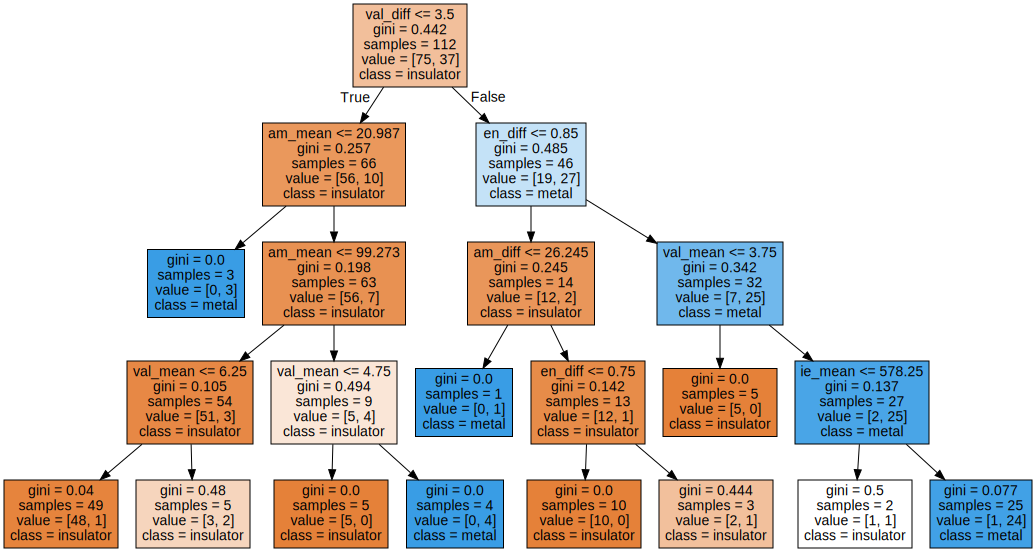

Feature importances:  [0.         0.20642109 0.01914225 0.         0.31718098 0.25108114
 0.16752343 0.03865112]


In [10]:
from sklearn.tree import export_graphviz
import graphviz

best_dtc = grid_search.best_estimator_.fit(x_train, y_train)

dot_graph = export_graphviz(best_dtc, class_names = ["insulator", "metal"], feature_names = ["en_mean", "en_diff", "ie_mean", "ie_diff", "val_mean", "val_diff", "am_mean", "am_diff"], filled = True)
display(graphviz.Source(dot_graph))

print("Feature importances: ", best_dtc.feature_importances_)

3. (2x) Neural network for regression.



(a) Read in the JSON file with the cleaned electronic band gap data for zincblende structure materials, and the JSON file with the elemental properties. Convert both to dictionary-like objects.


In [11]:
import json
from google.colab import drive
drive.mount('/content/drive')

f = open("/content/drive/MyDrive/Colab Notebooks/rocksalt_Egap_insulators_AFLOW.json", "r+")
zincblende_EgapClean = json.load(f)
f.close()
# print(zincblende_EgapClean)  #  already in dictionary-like form

f2 = open("/content/drive/MyDrive/Colab Notebooks/Chemical_element_data.json", "r+")
Chemical_element_data = json.load(f2)
f2.close()
# print(Chemical_element_data)  #  already in dictionary-like form

drive.flush_and_unmount()

Mounted at /content/drive


(b) Generate the feature vectors based on the means and differences of the electronegativities, ionization energies, valences and atomic masses (8 features, see example in Lecture 17). Generate the training and test sets.

In [12]:
x_list = []
y_list = []

for datum in zincblende_EgapClean:
    species1 = datum["species"][0]
    species2 = datum["species"][1]
    en_mean = abs(Chemical_element_data[species1]["electronegativity"] + Chemical_element_data[species2]["electronegativity"]) / 2.0
    en_diff = abs(Chemical_element_data[species1]["electronegativity"] - Chemical_element_data[species2]["electronegativity"])
    ie_mean = abs(Chemical_element_data[species1]["first_ionization_energy"] + Chemical_element_data[species2]["first_ionization_energy"]) / 2.0
    ie_diff = abs(Chemical_element_data[species1]["first_ionization_energy"] - Chemical_element_data[species2]["first_ionization_energy"])
    val_mean = abs(Chemical_element_data[species1]["valence"] + Chemical_element_data[species2]["valence"]) / 2.0
    val_diff = abs(Chemical_element_data[species1]["valence"] - Chemical_element_data[species2]["valence"])
    am_mean = abs(Chemical_element_data[species1]["atomic_mass"] + Chemical_element_data[species2]["atomic_mass"]) / 2.0
    am_diff = abs(Chemical_element_data[species1]["atomic_mass"] - Chemical_element_data[species2]["atomic_mass"])
    x_list.append([en_mean, en_diff, ie_mean, ie_diff, val_mean, val_diff, am_mean, am_diff])
    y_list.append(float(datum["Egap"]))

#  Training and testing sets will be generated in part (c)

(c) Split the data into testing and training sets. Rescale the data on the training set. Fit a neural network with 20 hidden layers and 8 nodes per layer, the lbfgs solver, the RELU activation function, and a regularization ('alpha') value of 1.0.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import numpy as np

x = np.array(x_list)
y = np.array(y_list)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

mlp = MLPRegressor(solver = "lbfgs", random_state = 0, hidden_layer_sizes = [20, 8], activation = "relu", alpha = 1.0, max_iter = 20000)
mlp.fit(x_train_scaled, y_train)

MLPRegressor(alpha=1.0, hidden_layer_sizes=[20, 8], max_iter=20000,
             random_state=0, solver='lbfgs')



(d) Use Grid Search cross-validation and Pipeline to optimize the value of alpha, with alpha values between 0.01 and 100, increasing by factors of 10. What is the score for the test set with the optimized parameters?

In [14]:
#  Import GridSearchCV and Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#  Instantiate Pipeline
pl = Pipeline([("scaler", StandardScaler()), ("mlp", MLPRegressor(random_state = 0, hidden_layer_sizes = [20, 8], max_iter = 20000))])

#  Generate dict containing alpha values
param_grid = {"mlp__alpha":[0.01, 0.1, 1.0, 10.0, 100.0]}

#  Instantiate GridSearchCV object, and fit to training set
grid_search = GridSearchCV(pl, param_grid = param_grid, return_train_score = True)
grid_search.fit(x_train, y_train)

#  Generate best accuracy on training set and accuracy on testing set
print("Best accuracy on training set: ", grid_search.best_score_)
print("Accuracy on test set: ", grid_search.score(x_test, y_test))

#  Print out parameters leading to best model
print("Best estimator: ", grid_search.best_estimator_)

Best accuracy on training set:  0.7282276910677667
Accuracy on test set:  0.6342391138265993
Best estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(alpha=1.0, hidden_layer_sizes=[20, 8],
                              max_iter=20000, random_state=0))])
